# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import os

from scipy import stats

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, Imputer,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve,roc_auc_score,accuracy_score

import matplotlib.pyplot as plt

import xgboost



#from sklearn.decomposition import PCA
#import lightgbm

# Exploratory Data Analysis

In [5]:
app_train = pd.read_csv(r'/root/shared/My_Practice/AML-HCDR/Data/application_train.csv')
app_test =  pd.read_csv(r'/root/shared/My_Practice/AML-HCDR/Data/application_test.csv')

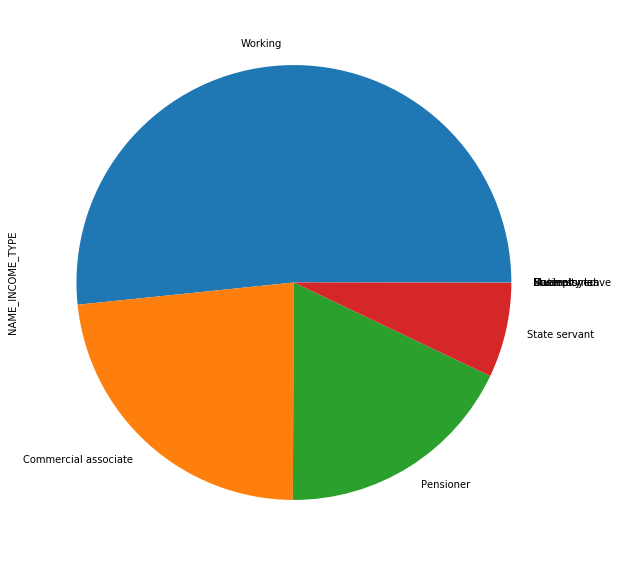

In [8]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.plotly import iplot
temp = app_train["NAME_INCOME_TYPE"].value_counts()
temp.plot.pie(y='mass', figsize=(10, 10))

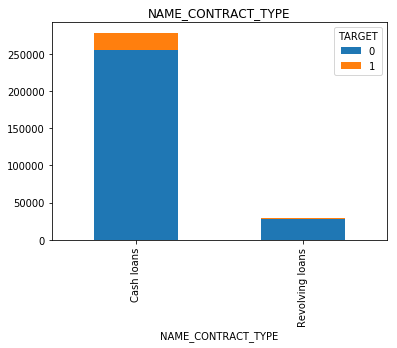

In [9]:
NAME_CONTRACT_TYPE = app_train.groupby(['TARGET','NAME_CONTRACT_TYPE']).size().unstack(level=0)
plt.subplot(NAME_CONTRACT_TYPE.plot(kind='bar', stacked=True, title="NAME_CONTRACT_TYPE"))

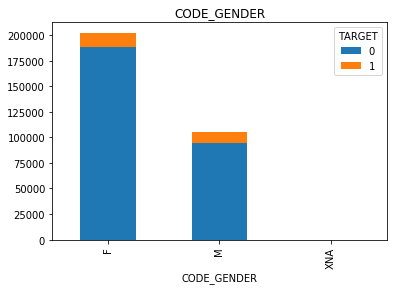

In [10]:
CODE_GENDER = app_train.groupby(['TARGET','CODE_GENDER']).size().unstack(level=0)
plt.subplot(CODE_GENDER.plot(kind='bar', stacked=True, title="CODE_GENDER"))

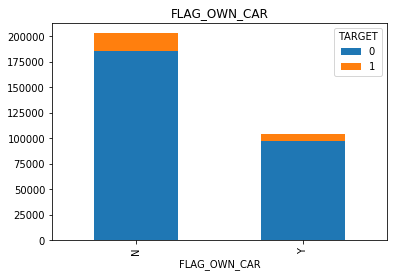

In [11]:
FLAG_OWN_CAR = app_train.groupby(['TARGET','FLAG_OWN_CAR']).size().unstack(level=0)
plt.subplot(FLAG_OWN_CAR.plot(kind='bar', stacked=True, title="FLAG_OWN_CAR"))

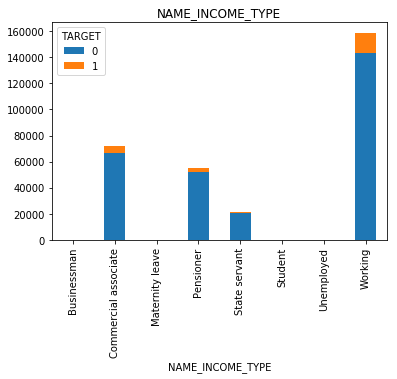

In [12]:
NAME_INCOME_TYPE = app_train.groupby(['TARGET','NAME_INCOME_TYPE']).size().unstack(level=0)
plt.subplot(NAME_INCOME_TYPE.plot(kind='bar', stacked=True, title="NAME_INCOME_TYPE"))

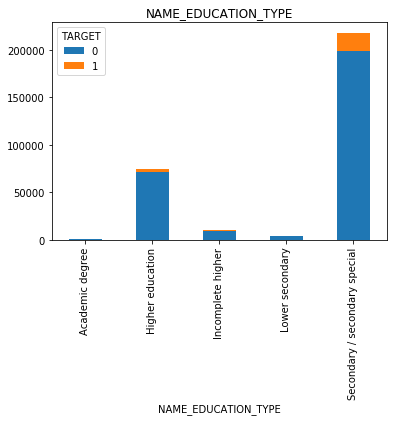

In [13]:
NAME_EDUCATION_TYPE = app_train.groupby(['TARGET','NAME_EDUCATION_TYPE']).size().unstack(level=0)
plt.subplot(NAME_EDUCATION_TYPE.plot(kind='bar', stacked=True, title="NAME_EDUCATION_TYPE"))

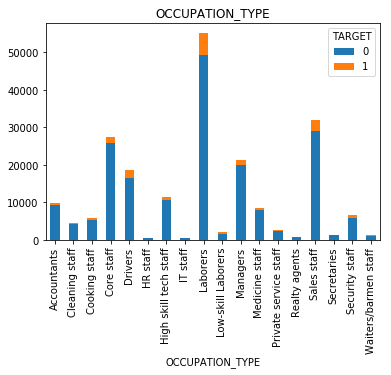

In [14]:
OCCUPATION_TYPE = app_train.groupby(['TARGET','OCCUPATION_TYPE']).size().unstack(level=0)
plt.subplot(OCCUPATION_TYPE.plot(kind='bar', stacked=True, title="OCCUPATION_TYPE"))


# Functions to Load the data and Transform the data

In [15]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [49]:
def previous_app():
    df_pa = pd.read_csv('previous_application.csv')
    df_pa.drop('SK_ID_PREV', axis = 1, inplace = True)
    

    
    numcols = df_pa.select_dtypes(exclude= 'object').columns
    catcols = df_pa.select_dtypes(include= 'object').columns

    num = df_pa[numcols]
    cat = df_pa[catcols]
    
    num.index = num['SK_ID_CURR']
    cat.index = num['SK_ID_CURR']
    
    catind = cat.index


    num.drop('SK_ID_CURR', inplace= True, axis = 1)
    num = num.groupby('SK_ID_CURR').agg([np.sum, np.mean,max,min])  
    num.columns = num.columns.map('_'.join)
    mdl = StandardScaler().fit(num)
    num = pd.DataFrame(mdl.transform(num),index = num.index, columns = num.columns)


    cat = SimpleImputer(strategy='constant').fit_transform(cat)
    mdl = OneHotEncoder().fit(cat)

    cat = pd.DataFrame(mdl.transform(cat).toarray(), index = catind, columns = mdl.get_feature_names())
    cat = cat.groupby('SK_ID_CURR').agg(np.mean)
    final = num.merge(cat, how = 'left', on = 'SK_ID_CURR')
    return final


In [50]:
def load_train():
    df_train = pd.read_csv('application_train.csv')
    #df_train = df_train.iloc[0:10000,]
    selected_features = ['SK_ID_CURR','AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
                    'EXT_SOURCE_2','EXT_SOURCE_3','CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR',
                     'NAME_CONTRACT_TYPE','NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE']

    df_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
    plt.xlabel('Days Employment');
    
    df_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)    
    df_train['DAYS_BIRTH'] = df_train['DAYS_BIRTH']/-365

    
    X_train= df_train[selected_features]
    y_train = df_train['TARGET']


    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify  = y_train)

    X_val_ind = X_valid['SK_ID_CURR']



    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.15, random_state=42,stratify  = y_train)

    X_train_ind = X_train['SK_ID_CURR']
    X_test_ind = X_test['SK_ID_CURR']


    X_valid.drop('SK_ID_CURR', inplace = True , axis = 1)
    X_train.drop('SK_ID_CURR', inplace = True , axis = 1)
    X_test.drop('SK_ID_CURR', inplace = True , axis = 1)
    
    return X_train, y_train, X_valid, y_valid, X_test, y_test, X_train_ind, X_val_ind, X_test_ind

In [51]:
def transform_train(X_train, X_valid, X_test, X_train_ind, X_val_ind, X_test_ind):
    num_attribs = ['AMT_INCOME_TOTAL',  'AMT_CREDIT','DAYS_EMPLOYED','DAYS_BIRTH','EXT_SOURCE_1',
                   'EXT_SOURCE_2','EXT_SOURCE_3']

    cat_attribs = ['CODE_GENDER', 'FLAG_OWN_REALTY','FLAG_OWN_CAR','NAME_CONTRACT_TYPE', 
                   'NAME_EDUCATION_TYPE','OCCUPATION_TYPE','NAME_INCOME_TYPE']


    num_pipeline = Pipeline([
                            ('selector', DataFrameSelector(num_attribs)),
                            ('imputer', SimpleImputer(strategy='mean')),
                            ('std_scaler', StandardScaler()),
                           ])

    cat_pipeline = Pipeline([
                            ('selector', DataFrameSelector(cat_attribs)),
                            ('imputer', SimpleImputer(strategy='constant')),
                            ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore"))
                            ])

    data_prep_pipeline = FeatureUnion(transformer_list=[
                                                        ("num_pipeline", num_pipeline),
                                                        ("cat_pipeline", cat_pipeline),
                                                       ])

    full_pipeline = Pipeline([("preparation", data_prep_pipeline)])

    X_train = pd.DataFrame(full_pipeline.fit_transform(X_train), index  = X_train_ind)
    X_valid = pd.DataFrame(full_pipeline.transform(X_valid), index = X_val_ind)
    X_test = pd.DataFrame(full_pipeline.transform(X_test), index= X_test_ind)
    
    return full_pipeline, X_train, X_valid, X_test

# Baseline Model 

In [ ]:
def BaselineApproach(fitted_models,expLog, X_train,X_valid, X_test,y_train,y_test,y_valid):
    models = [LogisticRegression(n_jobs = -1, solver = 'lbfgs')
          ,RandomForestClassifier(n_jobs = -1,n_estimators = 100)]
    
    models_name = ['Logistic','RandomForest']
    ctr = 0
    p_value = 0
    for model in models:
        cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
        np.random.seed(42)
        model.fit(X_train, y_train)
        exp_name = f"Model_{models_name[ctr]}_features_{X_train.shape[1]}"
        fitted_models.append(model)
        if ctr   == 0:
            logit_scores = cross_val_score(model, X_train, y_train, cv=cv)
        else:
            best_train_scores = cross_val_score(model, X_train, y_train, cv=cv)
            (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)

        expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
                   [accuracy_score(y_train, model.predict(X_train)), 
                    accuracy_score(y_valid, model.predict(X_valid)),
                    accuracy_score(y_test, model.predict(X_test)),
                    roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                    roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                    roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),p_value],
                    4)) 
        ctr += 1
    return logit_scores

# Merge the data with Previous Application File

In [53]:
def merge_df(X_train, X_valid, X_test, df_pv_app):
    X_train = X_train.merge(df_pv_app, how = 'left', on = 'SK_ID_CURR')
    X_valid = X_valid.merge(df_pv_app, how = 'left', on = 'SK_ID_CURR')
    X_test =  X_test.merge(df_pv_app, how = 'left', on = 'SK_ID_CURR')


    X_train.fillna(0, inplace = True)
    X_valid.fillna(0, inplace = True)
    X_test.fillna(0, inplace = True)
    
    return X_train, X_valid, X_test

# Function that extends baseline model with supporting CSV

In [54]:
def BaselinPlusPvApp(logit_scores,fitted_models,expLog, X_train,X_valid, X_test,y_train,y_test,y_valid):
    models = [LogisticRegression(n_jobs = -1, solver = 'lbfgs' )
              ,RandomForestClassifier(n_jobs = -1,n_estimators = 100)]
    models_name = ['Logistic_Prev_app','RandomForest_prev_app']
    ctr = 0
    p_value = 0
    for model in models:
        cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
        np.random.seed(42)
        model.fit(X_train, y_train)
        exp_name = f"Model_{models_name[ctr]}_features_{X_train.shape[1]}"
        fitted_models.append(model)
        best_train_scores = cross_val_score(model, X_train, y_train, cv=cv)
        (t_stat, p_value) = stats.ttest_rel(logit_scores, best_train_scores)

        expLog.loc[len(expLog)] = [f"{exp_name}"] + list(np.round(
                   [accuracy_score(y_train, model.predict(X_train)), 
                    accuracy_score(y_valid, model.predict(X_valid)),
                    accuracy_score(y_test, model.predict(X_test)),
                    roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
                    roc_auc_score(y_valid, model.predict_proba(X_valid)[:, 1]),
                    roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]),p_value],
                    4)) 
        ctr += 1

# Calculate the performance metrics of fitted models.

,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,Model_Logistic_features_48,0.9191,0.9192,0.9196,0.7357,0.7407,0.7450,0.0000
1,Model_RandomForest_features_48,0.9999,0.9194,0.9194,1.0000,0.7100,0.7169,0.1024


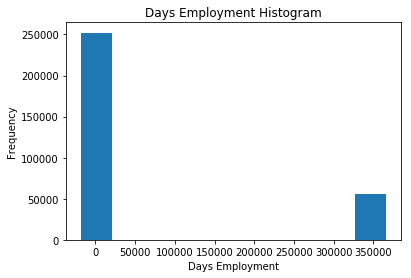

In [55]:
fitted_models = []
expLog = pd.DataFrame(columns=["exp_name", 
                               "Train Acc", 
                               "Valid Acc",
                               "Test  Acc",
                               "Train AUC", 
                               "Valid AUC",
                               "Test  AUC",
                               "P_Value"
                              ])

#Loading & Transforming Train
X_train, y_train, X_valid, y_valid, X_test, y_test, X_train_ind, X_val_ind, X_test_ind = load_train()

full_pipeline, X_train, X_valid, X_test = transform_train(X_train, X_valid, X_test, X_train_ind, X_val_ind, X_test_ind)

#BaselIne Model
logit_scores_baseline = BaselineApproach(fitted_models,expLog, X_train,X_valid, X_test,y_train,y_test,y_valid)
expLog



# adding Previous application to Data

In [56]:
df_pv_app = previous_app()
X_train, X_valid, X_test = merge_df(X_train, X_valid, X_test, df_pv_app)
BaselinPlusPvApp(logit_scores_baseline,fitted_models,expLog, X_train,X_valid, X_test,y_train,y_test,y_valid)
expLog

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


,exp_name,Train Acc,Valid Acc,Test Acc,Train AUC,Valid AUC,Test AUC,P_Value
0,Model_Logistic_features_48,0.9191,0.9192,0.9196,0.7357,0.7407,0.7450,0.0000
1,Model_RandomForest_features_48,0.9999,0.9194,0.9194,1.0000,0.7100,0.7169,0.1024
2,Model_Logistic_Prev_app_features_269,0.9193,0.9194,0.9196,0.7567,0.7584,0.7601,0.0068
3,Model_RandomForest_prev_app_features_269,1.0000,0.9194,0.9195,1.0000,0.7168,0.7197,0.0000


# Using XGBoost

In [57]:
xgb_model =xgboost.XGBClassifier(tree_method = 'hist'  #used to increase training time
                                 ,objective ='binary:logistic'
                                 , booster='gbtree'
                                 , n_jobs=-1
                                 , n_estimators = 1000 
                                 , learning_rate=0.05
                                 , reg_alpha = 0.01
                                 , gamma=3
                                , max_depth= 6)

In [58]:
xgb_model.fit(X_train, y_train
        ,eval_set=[(X_train, y_train),(X_test, y_test), (X_valid, y_valid)]
        ,eval_metric=['logloss','auc']
        ,early_stopping_rounds = 100   
        ,verbose=True)


[0]	validation_0-logloss:0.657983	validation_0-auc:0.719135	validation_1-logloss:0.658033	validation_1-auc:0.719438	validation_2-logloss:0.658002	validation_2-auc:0.720298
Multiple eval metrics have been passed: 'validation_2-auc' will be used for early stopping.

Will train until validation_2-auc hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.626173	validation_0-auc:0.722468	validation_1-logloss:0.626279	validation_1-auc:0.721651	validation_2-logloss:0.626198	validation_2-auc:0.722534
[2]	validation_0-logloss:0.597293	validation_0-auc:0.726136	validation_1-logloss:0.597462	validation_1-auc:0.725059	validation_2-logloss:0.59736	validation_2-auc:0.72444
[3]	validation_0-logloss:0.570994	validation_0-auc:0.728568	validation_1-logloss:0.57121	validation_1-auc:0.726499	validation_2-logloss:0.571114	validation_2-auc:0.726243
[4]	validation_0-logloss:0.546961	validation_0-auc:0.729911	validation_1-logloss:0.547206	validation_1-auc:0.728847	validation_2-logloss:0.547141	validation_

[47]	validation_0-logloss:0.260244	validation_0-auc:0.758679	validation_1-logloss:0.262914	validation_1-auc:0.743137	validation_2-logloss:0.263247	validation_2-auc:0.741787
[48]	validation_0-logloss:0.259219	validation_0-auc:0.759252	validation_1-logloss:0.261999	validation_1-auc:0.743255	validation_2-logloss:0.262323	validation_2-auc:0.741953
[49]	validation_0-logloss:0.258245	validation_0-auc:0.75994	validation_1-logloss:0.261142	validation_1-auc:0.743332	validation_2-logloss:0.261435	validation_2-auc:0.742321
[50]	validation_0-logloss:0.25732	validation_0-auc:0.760586	validation_1-logloss:0.260335	validation_1-auc:0.74364	validation_2-logloss:0.260609	validation_2-auc:0.742715
[51]	validation_0-logloss:0.256475	validation_0-auc:0.761053	validation_1-logloss:0.259577	validation_1-auc:0.743876	validation_2-logloss:0.25987	validation_2-auc:0.742912
[52]	validation_0-logloss:0.255631	validation_0-auc:0.761839	validation_1-logloss:0.258849	validation_1-auc:0.744206	validation_2-logloss:0

[95]	validation_0-logloss:0.239412	validation_0-auc:0.789033	validation_1-logloss:0.246829	validation_1-auc:0.759095	validation_2-logloss:0.24758	validation_2-auc:0.757798
[96]	validation_0-logloss:0.239212	validation_0-auc:0.789522	validation_1-logloss:0.246733	validation_1-auc:0.759243	validation_2-logloss:0.247512	validation_2-auc:0.757886
[97]	validation_0-logloss:0.239049	validation_0-auc:0.789905	validation_1-logloss:0.246647	validation_1-auc:0.759401	validation_2-logloss:0.247434	validation_2-auc:0.758012
[98]	validation_0-logloss:0.238877	validation_0-auc:0.79025	validation_1-logloss:0.246572	validation_1-auc:0.759512	validation_2-logloss:0.247368	validation_2-auc:0.758117
[99]	validation_0-logloss:0.238708	validation_0-auc:0.790645	validation_1-logloss:0.246514	validation_1-auc:0.759589	validation_2-logloss:0.247289	validation_2-auc:0.75831
[100]	validation_0-logloss:0.238509	validation_0-auc:0.791132	validation_1-logloss:0.246414	validation_1-auc:0.759786	validation_2-logloss

[143]	validation_0-logloss:0.23244	validation_0-auc:0.805884	validation_1-logloss:0.2443	validation_1-auc:0.764498	validation_2-logloss:0.245261	validation_2-auc:0.762999
[144]	validation_0-logloss:0.232343	validation_0-auc:0.806165	validation_1-logloss:0.244286	validation_1-auc:0.764541	validation_2-logloss:0.245233	validation_2-auc:0.763057
[145]	validation_0-logloss:0.232171	validation_0-auc:0.806597	validation_1-logloss:0.24422	validation_1-auc:0.764681	validation_2-logloss:0.245172	validation_2-auc:0.76324
[146]	validation_0-logloss:0.232038	validation_0-auc:0.806944	validation_1-logloss:0.24419	validation_1-auc:0.764717	validation_2-logloss:0.245123	validation_2-auc:0.763387
[147]	validation_0-logloss:0.231938	validation_0-auc:0.807245	validation_1-logloss:0.244192	validation_1-auc:0.764671	validation_2-logloss:0.245094	validation_2-auc:0.763476
[148]	validation_0-logloss:0.231807	validation_0-auc:0.807591	validation_1-logloss:0.244172	validation_1-auc:0.76471	validation_2-loglos

[191]	validation_0-logloss:0.227463	validation_0-auc:0.81854	validation_1-logloss:0.243435	validation_1-auc:0.766092	validation_2-logloss:0.24447	validation_2-auc:0.764908
[192]	validation_0-logloss:0.22737	validation_0-auc:0.818796	validation_1-logloss:0.243427	validation_1-auc:0.766098	validation_2-logloss:0.24448	validation_2-auc:0.764851
[193]	validation_0-logloss:0.227254	validation_0-auc:0.819084	validation_1-logloss:0.243414	validation_1-auc:0.766098	validation_2-logloss:0.244452	validation_2-auc:0.76494
[194]	validation_0-logloss:0.227164	validation_0-auc:0.8193	validation_1-logloss:0.243413	validation_1-auc:0.766104	validation_2-logloss:0.244441	validation_2-auc:0.76497
[195]	validation_0-logloss:0.227072	validation_0-auc:0.819557	validation_1-logloss:0.243392	validation_1-auc:0.766156	validation_2-logloss:0.24443	validation_2-auc:0.765001
[196]	validation_0-logloss:0.226953	validation_0-auc:0.819803	validation_1-logloss:0.243361	validation_1-auc:0.76624	validation_2-logloss:0

[239]	validation_0-logloss:0.223377	validation_0-auc:0.829015	validation_1-logloss:0.242988	validation_1-auc:0.767187	validation_2-logloss:0.244157	validation_2-auc:0.765845
[240]	validation_0-logloss:0.223317	validation_0-auc:0.829223	validation_1-logloss:0.242988	validation_1-auc:0.767188	validation_2-logloss:0.244157	validation_2-auc:0.765866
[241]	validation_0-logloss:0.223246	validation_0-auc:0.829437	validation_1-logloss:0.242991	validation_1-auc:0.767148	validation_2-logloss:0.244143	validation_2-auc:0.765887
[242]	validation_0-logloss:0.223208	validation_0-auc:0.829548	validation_1-logloss:0.242995	validation_1-auc:0.767114	validation_2-logloss:0.244139	validation_2-auc:0.765903
[243]	validation_0-logloss:0.223162	validation_0-auc:0.829643	validation_1-logloss:0.243003	validation_1-auc:0.767099	validation_2-logloss:0.244134	validation_2-auc:0.765909
[244]	validation_0-logloss:0.223076	validation_0-auc:0.829888	validation_1-logloss:0.242977	validation_1-auc:0.767194	validation_2

[287]	validation_0-logloss:0.220216	validation_0-auc:0.837226	validation_1-logloss:0.242843	validation_1-auc:0.767409	validation_2-logloss:0.24404	validation_2-auc:0.766151
[288]	validation_0-logloss:0.220148	validation_0-auc:0.837414	validation_1-logloss:0.242848	validation_1-auc:0.767397	validation_2-logloss:0.244019	validation_2-auc:0.766242
[289]	validation_0-logloss:0.220084	validation_0-auc:0.837589	validation_1-logloss:0.242846	validation_1-auc:0.767409	validation_2-logloss:0.244008	validation_2-auc:0.766266
[290]	validation_0-logloss:0.219997	validation_0-auc:0.837783	validation_1-logloss:0.242823	validation_1-auc:0.767456	validation_2-logloss:0.243998	validation_2-auc:0.766299
[291]	validation_0-logloss:0.219934	validation_0-auc:0.837957	validation_1-logloss:0.242829	validation_1-auc:0.767444	validation_2-logloss:0.244004	validation_2-auc:0.766288
[292]	validation_0-logloss:0.21982	validation_0-auc:0.838251	validation_1-logloss:0.242822	validation_1-auc:0.767464	validation_2-l

[335]	validation_0-logloss:0.217255	validation_0-auc:0.84463	validation_1-logloss:0.242661	validation_1-auc:0.76779	validation_2-logloss:0.243983	validation_2-auc:0.766316
[336]	validation_0-logloss:0.217165	validation_0-auc:0.844853	validation_1-logloss:0.242663	validation_1-auc:0.767782	validation_2-logloss:0.243994	validation_2-auc:0.766304
[337]	validation_0-logloss:0.217113	validation_0-auc:0.845014	validation_1-logloss:0.24266	validation_1-auc:0.767776	validation_2-logloss:0.243996	validation_2-auc:0.766299
[338]	validation_0-logloss:0.217013	validation_0-auc:0.845293	validation_1-logloss:0.24268	validation_1-auc:0.767722	validation_2-logloss:0.243978	validation_2-auc:0.766346
[339]	validation_0-logloss:0.216971	validation_0-auc:0.845402	validation_1-logloss:0.242674	validation_1-auc:0.767739	validation_2-logloss:0.24397	validation_2-auc:0.766381
[340]	validation_0-logloss:0.21694	validation_0-auc:0.845462	validation_1-logloss:0.242682	validation_1-auc:0.767703	validation_2-loglo

[383]	validation_0-logloss:0.214568	validation_0-auc:0.851111	validation_1-logloss:0.242599	validation_1-auc:0.76786	validation_2-logloss:0.243983	validation_2-auc:0.76639
[384]	validation_0-logloss:0.214534	validation_0-auc:0.851168	validation_1-logloss:0.242599	validation_1-auc:0.76785	validation_2-logloss:0.24399	validation_2-auc:0.766388
[385]	validation_0-logloss:0.214518	validation_0-auc:0.851215	validation_1-logloss:0.242594	validation_1-auc:0.767866	validation_2-logloss:0.243994	validation_2-auc:0.766373
[386]	validation_0-logloss:0.214463	validation_0-auc:0.851327	validation_1-logloss:0.242597	validation_1-auc:0.767848	validation_2-logloss:0.24401	validation_2-auc:0.766334
[387]	validation_0-logloss:0.214385	validation_0-auc:0.85154	validation_1-logloss:0.242595	validation_1-auc:0.767883	validation_2-logloss:0.243999	validation_2-auc:0.766395
[388]	validation_0-logloss:0.214364	validation_0-auc:0.8516	validation_1-logloss:0.242593	validation_1-auc:0.767886	validation_2-logloss

[431]	validation_0-logloss:0.212201	validation_0-auc:0.856888	validation_1-logloss:0.242581	validation_1-auc:0.768032	validation_2-logloss:0.244017	validation_2-auc:0.766401
[432]	validation_0-logloss:0.212104	validation_0-auc:0.857113	validation_1-logloss:0.242576	validation_1-auc:0.768032	validation_2-logloss:0.244012	validation_2-auc:0.766426
[433]	validation_0-logloss:0.212015	validation_0-auc:0.857386	validation_1-logloss:0.242575	validation_1-auc:0.768026	validation_2-logloss:0.244013	validation_2-auc:0.766424
[434]	validation_0-logloss:0.211989	validation_0-auc:0.857431	validation_1-logloss:0.242583	validation_1-auc:0.767998	validation_2-logloss:0.244022	validation_2-auc:0.766393
[435]	validation_0-logloss:0.211968	validation_0-auc:0.857486	validation_1-logloss:0.242586	validation_1-auc:0.768	validation_2-logloss:0.244022	validation_2-auc:0.766387
[436]	validation_0-logloss:0.211882	validation_0-auc:0.857718	validation_1-logloss:0.242577	validation_1-auc:0.768035	validation_2-lo

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=3, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0.01, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, tree_method='hist')

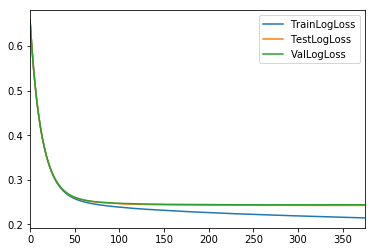

In [32]:
evals_result = xgb_model.evals_result()
evals = pd.DataFrame(evals_result['validation_0']['logloss'], columns  = ['TrainLogLoss'])
evals['TestLogLoss'] = evals_result['validation_1']['logloss']
evals['ValLogLoss'] = evals_result['validation_2']['logloss']
evals.plot()

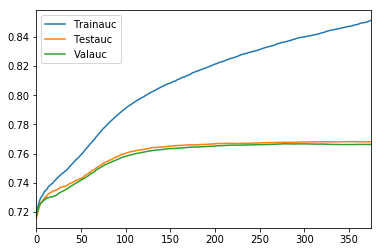

In [33]:
auc = pd.DataFrame(evals_result['validation_0']['auc'], columns  = ['Trainauc'])
auc['Testauc'] = evals_result['validation_1']['auc']
auc['Valauc'] = evals_result['validation_2']['auc']
auc.plot()

In [36]:
fitted_models.append(xgb_model)

# Prepare the submission data

In [41]:
def test_sub(full_pipeline,df_pv_app,fitted_models):
    df_test = pd.read_csv('application_test.csv')
    df_test['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)    
    df_test['DAYS_BIRTH'] = df_test['DAYS_BIRTH']/-365
    
    
    tst_ind = df_test['SK_ID_CURR']
    test = pd.DataFrame(full_pipeline.transform(df_test), index = tst_ind)
    test = test.merge(df_pv_app, how = 'left', on = 'SK_ID_CURR')
    test.fillna(0,inplace = True)
    pred = fitted_models[5].predict_proba(test)[:,1]
    sub = pd.DataFrame(tst_ind)
    sub['TARGET'] = pred
    sub.to_csv('submission.csv', index = False)


In [44]:
#test_sub(full_pipeline,df_pv_app,fitted_models)
#!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "XGBoost - Hist"
!kaggle competitions submissions home-credit-default-risk

fileName           date                 description                                                                    status    publicScore  privateScore  
-----------------  -------------------  -----------------------------------------------------------------------------  --------  -----------  ------------  
submission.csv     2019-04-06 22:05:28  XGBoost - Hist                                                                 complete  0.74886      0.75185       
submission.csv     2019-04-06 08:47:56  LogR - With Previous APP Data(actual2)                                         complete  0.74340      0.74151       
submission.csv     2019-04-06 08:47:22  LogR - With Previous APP Data(actual)                                          complete  0.60422      0.61406       
submission.csv     2019-04-06 08:47:12  LogR - With Previous APP Data                                                  complete  0.60422      0.61406       
submission.csv     2019-04-06 08:46:56  RF - With Previous

# Analysis

We extended our exploratory analysis and used standard preprocessing steps to remove the anamolies 
We used standard sklearn preprocessing libraries to impute the missing data. 
The formatted data then merged with previous application csv data to extract basic statistical features such mean,sum,max and min.
We immedietly observed the accuracy boost from 74% to 76% to the baseline logistic regression model. 
We did not observe the same improvement in accuracy on Random Forest alogrithm.
Approximately we see the convergence at 150 epochs as for AUC score and Logloss.
So far we have explored only one supporting dataset, the below steps explain our approach for the next phase.

* Explore new features (Use other CSV files)
* Improve models
* Feature selection using Sci-kit learn or PCA
* Hyper parameter tuning
* Report finding and decisions using performance metrics.

